# Mapping America's Police Departments
In June of 2018, East Pittsburgh Police officer Michael Rosfeld shot 17 year old Antwan Rose Jr. in the back, killing him. Rose was one of several passengers fleeing a jitney which Police had stopped for being visually connected to a recent shooting. But Rose did not know the other passengers and had not committed any crime. In a surprising turn of events, after heavy protests from the community shut down major roads in Pittsburgh, Officer Rosfeld was arrested and charged with criminal homicide (although he was grainted bail and set free).

Officer Rosfeld's career in law enforcement up to this point was not exactly exemplary. Prior to joining East Pittsburgh PD (East Pittsburgh is a small borough outside the city, not a part of Pittsburgh proper), Rosfeld spent five years on the police force of the University of Pittsburgh. He left after a lawsuit alleged abuses in December of 2017. EPPD hired him a scant four months later.

A side note: In the press conference announcing Rosfeld's indictment, a reporter asked Allegheny County District Attorney Stephen Zappala about EPPD's policies regarding such situations. Zappala responded that, by all accounts, the department [has no policies about anything](https://twitter.com/meganguzaTrib/status/1011996036397780993).

Rosfeld's journey to East Pittsburgh via questionable departure from his last gig made me wonder if the sheer number of police departments in America could contribute to systematic abuse. (Similar questions about the balkanization of suburban St. Louis police came up in the aftermath of Ferguson as well.) So I decided to find a way to map America's police departments.

_This is a first draft._ The data is from [PoliceOne](http://www.policeone.com) and is entirely self-reported. It is incomplete, with some states missing entirely. But hopefully further interations will yield better data and, eventually, useful analysis. 

---

In [464]:
# imports
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import re
import requests
import unidecode
import string
import datetime
import time
from IPython.display import clear_output
import urllib3
import certifi

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Gathering the data
I scraped the name, number of officers and population represented for every police department listed on PoliceOne's directory using BeautifulSoup.

In [465]:
# list of states to iterate over
states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

In [150]:
# instantiate output dataframe
us_PD = pd.DataFrame()

# iterate over all states
for s in states:
    
    # instantiate 'zults' for output
    zults = {'name':[], 'url':[], 'pop':[], 'officers':[]}

    # make HTTP certificate
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())

    # create url for scraping
    state = '-'.join(s.lower().split())
    print(state)
    
    # reset page number
    n = 1

    # enable run condition
    run = True

    # scrapes page and then advances 'n' by 1
    while run:
        url = f'https://www.policeone.com/law-enforcement-directory/search/page-{n}/?state={state}&type=police%20departments'

        # start request
        r = http.request('GET', url)

        # check status
        if r.status == 200:
            soup = BeautifulSoup(r.data, 'lxml')
            
            # sets 'run' to False if no entries on page, ending scraping for that state
            if len(soup.find_all('a', {'class':'Table-row'})) == 0:
                run = False
                continue
                
            # scrape 'name' of PD and 'url' for individual page
            else:
                for span in soup.find_all('span', {'class':'u-textLink'}):
                    zults['name'].append(span.text.strip())
                for link in soup.find_all('a', {'class':'Table-row'}):
                    zults['url'].append(link['href'])
        n += 1

    # scrape linked data for all 'url'
    for l in zults['url']:
        print(l)
        
        # instantiate output dict
        data = {'dd':[],'dt':[]}
        
        # set new scrape target
        r3 = http.request('GET', f'https://www.policeone.com{l}')
        soup = BeautifulSoup(r3.data, 'lxml')
        
        # scrape entries
        for d in soup.find_all('dd', {'class':'DefList-description'}):
            data['dd'].append(d.text.strip())
        for t in soup.find_all('dt', {'class':'DefList-term'}):
            data['dt'].append(t.text.strip())
        d2 = dict(zip(data['dt'], data['dd']))
        
        # pull 'pop' and 'officers' or impute with 'missing'
        try:
            zults['pop'].append(d2['Population Served:'])
        except KeyError:
            zults['pop'].append('missing')
        try:
            zults['officers'].append(d2['Number of Officers:'])
        except KeyError:
            zults['officers'].append('missing')
    
    # create dataframe, fill 'state' column with name of state
    zult = pd.DataFrame(zults)
    zult['state'] = state
   
    # add 'zult' to output df
    us_PD = pd.concat([us_PD, zult])
    clear_output()      

After scraping, are any states missing?

In [158]:
for s in states:
    x = ('-'.join(s.lower().split()))
    if x not in us_PD['state'].unique():
        print(x)

rhode-island
vermont


# Data cleaning
--- 

Convert all numbers to integers or NA values.

In [12]:
def try_convert(x):
    try:
        return int(x)
    except ValueError:
        return np.NaN

In [14]:
us_PD.officers = us_PD.officers.map(try_convert)

In [15]:
us_PD['pop'] = us_PD['pop'].map(try_convert)

### Summing by state
'all_data' contains population, number of departments and number of officers by state.

In [19]:
sumo = us_PD.groupby('state').sum().reset_index()
counto = us_PD[['state','pop']].groupby('state').count().rename(columns={'pop':'depts'}).reset_index()
all_data = pd.merge(sumo, counto, on='state')

In [74]:
# cleaning up formatting in state names
all_data['state'] = all_data['state'].map(lambda x: x.replace('-', ' '))

### Adding real population
2016 state population pulled from census.gov.

In [66]:
real_pop = pd.read_csv('nst-est2016-popchg2010_2016.csv')
real_pop['NAME'] = real_pop[['NAME','POPESTIMATE2016']].NAME.map(lambda x: x.lower())

all_data = pd.merge(all_data, real_pop[['NAME','POPESTIMATE2016']], left_on='state', right_on='NAME').drop('NAME', axis=1).rename(columns={'POPESTIMATE2016':'real_pop_2016'})

### How much are we missing?
To get a sense of how incomplete this data might be, a couple charts comparing PoliceOne reported population and real population by state.

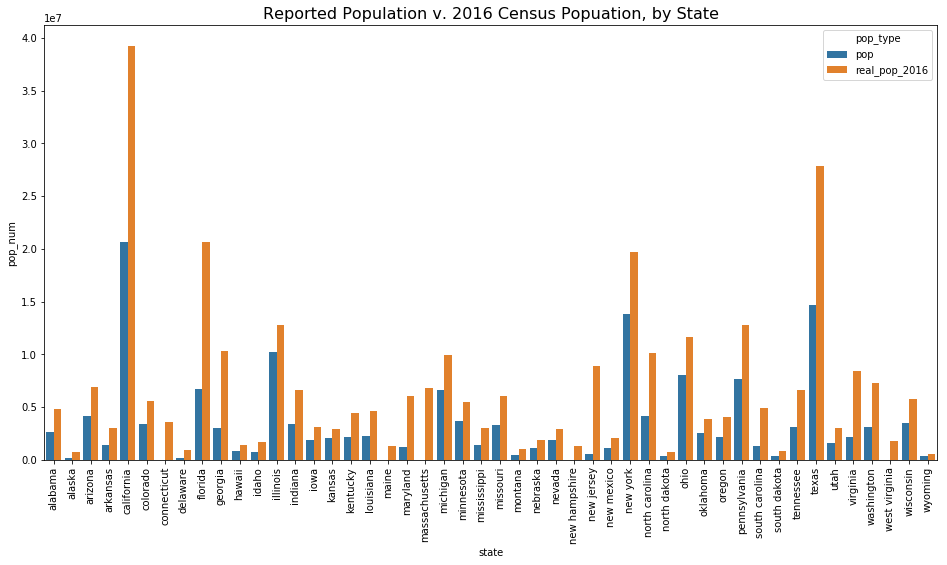

In [468]:
d = all_data.melt(id_vars=['state'], value_vars=['pop', 'real_pop_2016'], var_name='pop_type', value_name='pop_num') 

plt.figure(figsize=(16,8))
plt.title(s='Reported Population v. 2016 Census Popuation, by State', size=16)
sns.barplot(data=d, x='state', y='pop_num', hue='pop_type')
plt.xticks(rotation=90);

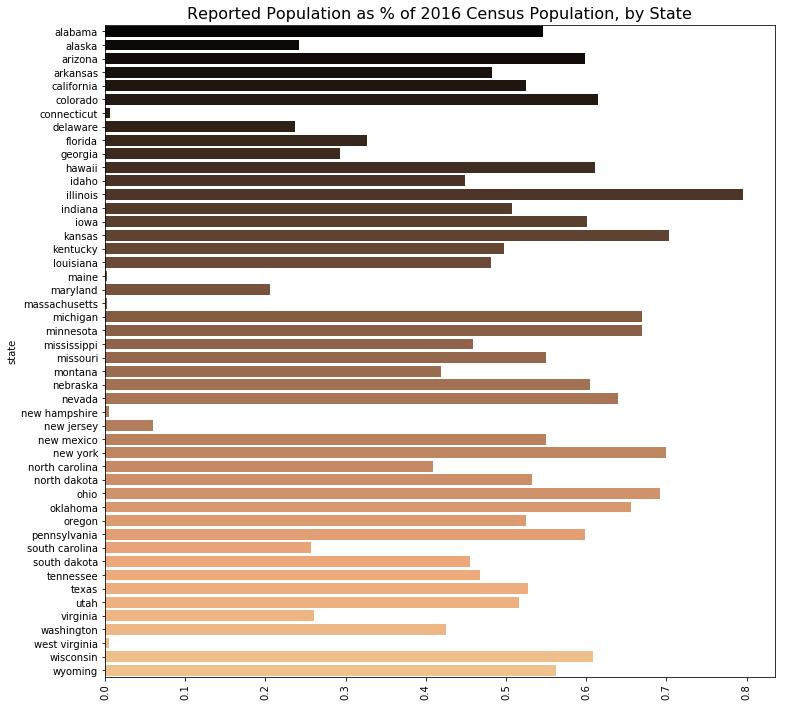

In [505]:
d = all_data

plt.figure(figsize=(12,12))
plt.title(s='Reported Population as % of 2016 Census Population, by State', size=16)
sns.barplot(data=d, y='state', x=(d['pop']/d['real_pop_2016']), palette='copper')
plt.xticks(rotation=90);

Looks like we are missing a lot. So procede with appropriate skepticism.

# Loading coordinates for mapping
Using [GeoPy](https://geopy.readthedocs.io/en/stable/) to pull longitude and latitude for every police department. GeoPy can pull coordinants from search terms, so to get the best guess at PD's location, I am feeding it the 'name' with common words ('Police','Safety' etc) stripped out, plus the name of the state.

In [506]:
# counting words in all PD names to gague common terms
words = {}
for pol in us_PD['name']:
    n2 = pol.split()
    for n in n2:
        if n in words.keys():
            words[n] += 1
        else:
            words[n] = 1

In [511]:
pd.DataFrame(words, index=['count']).T.sort_values('count', ascending=False).head(10)

,count
Department,9199
Police,9142
City,399
Township,328
Village,255
of,200
Lake,141
Safety,137
Public,133
Town,131


In [508]:
# the "stop words" to be stripped from PD names
stops = ['Department','Police', 'Safety', 'Public']

In [507]:
from geopy.geocoders import Nominatim

In [283]:
# creating empty columns for 'lat' and 'lon'
us_PD['lat'] = 0
us_PD['lon'] = 0

In [509]:
# a function to run on every row of 'us_PD' to pull coordinates
def pull_coords(row, stops = ['Department','Police', 'Safety', 'Public']):
    
    # get 'name' and 'state
    name = row['name']
    state = row['state']
    
    # strip stop words and combine with state
    full = [w for w in name.split() if w not in stops] + [state]

    # create geocode object
    loc = geolocator.geocode(full, timeout=10)

    # if they exist, pull latitude and longitude
    try:
        lat = loc.latitude
    except AttributeError:
        lat = np.NaN
    try:
        lon = loc.longitude
    except AttributeError:
        lon = np.NaN

    return (lat, lon)

This code iterates through all rows in 'us_PD', runs 'pull_cords' and fills in 'lat' and 'lon' with the results

It also runs time.sleep() to avoid 429 errors and contains print statements to track progress.

In [512]:
counter = 0
state = 'none'
for n in range(counter, us_PD.shape[0]+1):
    r = us_PD.iloc[n,:]
    new_state = r['state']
    if new_state != state:
        print(new_state)
        state = new_state
    c = pull_coords(r)
    us_PD.loc[n,'lat'] = c[0]
    us_PD.loc[n,'lon'] = c[1]
    time.sleep(1)
    print(r['name'])
    counter += 1   
    if counter % 50 == 0:
        clear_output()
        print(counter)
        print(state)

# Mapping the data
---

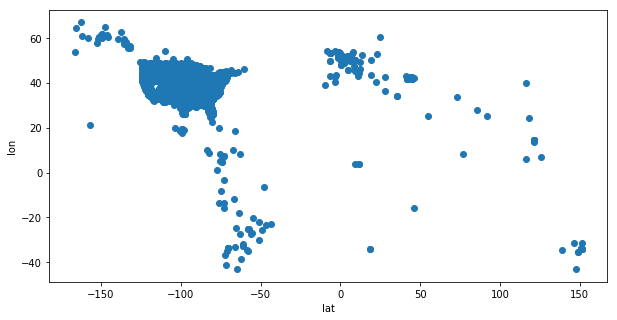

In [515]:
d = us_PD

plt.figure(figsize=(10,5))
plt.scatter(data=d, y='lat', x='lon')
plt.xlabel(s='lat')
plt.ylabel(s='lon');

Clearly there's a lot of wrong coordinates here. Some quick research puts the continental 48 states between -125, -70 longitude and 22,50 latitude. Subsetting 'us_PD' on those conditions.

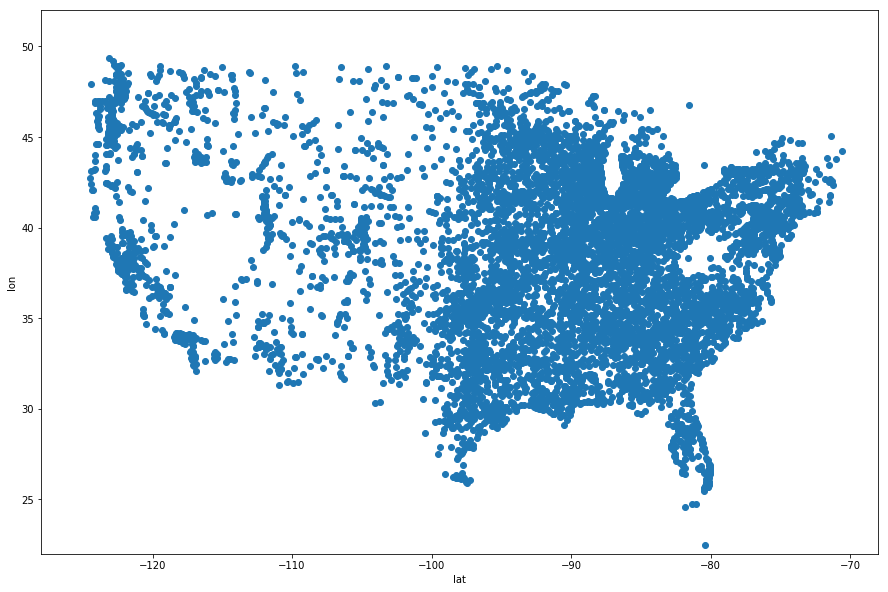

In [522]:
d = us_PD[(us_PD.lat < 50) & (us_PD.lat > 22) & (us_PD.lon < -70) & (us_PD.lon > -125)]

plt.figure(figsize=(15,10))
plt.scatter(data=d, y='lat', x='lon')
plt.xlim(-128, -68)
plt.ylim(22,52)
plt.xlabel(s='lat')
plt.ylabel(s='lon');

Now changing size and color of points to represent number of officers per PD.

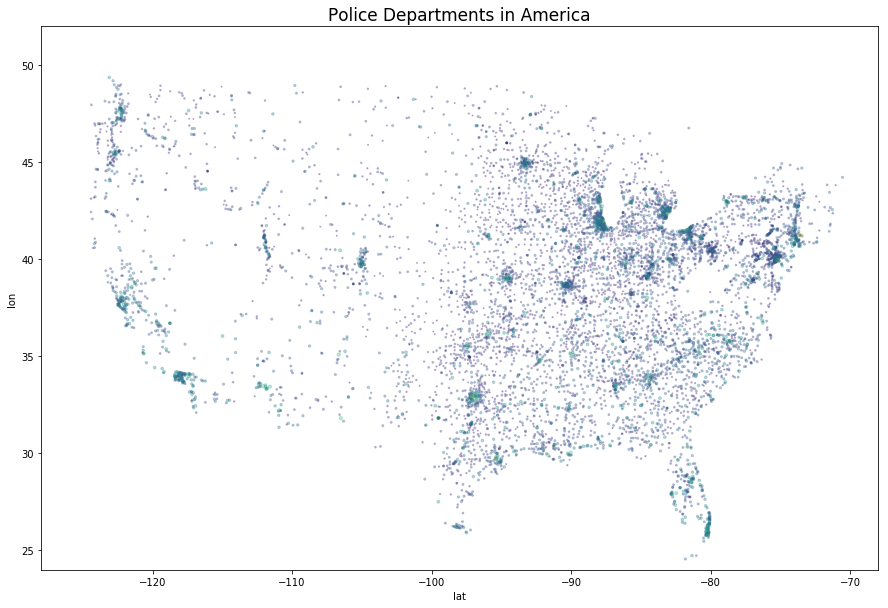

In [532]:
d = us_PD[(us_PD.lat < 50) & (us_PD.lat > 22) & (us_PD.lon < -70) & (us_PD.lon > -125)]

plt.figure(figsize=(15,10))
plt.title(s='Police Departments in America', size=17)
plt.scatter(data=d, y='lat', x='lon', s=np.log2(d['officers']), alpha=0.3, c=np.log2(d['officers']))
plt.xlim(-128, -68)
plt.ylim(24,52)
plt.xlabel(s='lat')
plt.ylabel(s='lon');

# Conclusion and next steps
---
As stated at the beginning of the article, this is only a starting point for further analysis. The data is spotty and the map doesn't show us much more than a vague notion that the police are where the people are. However, as I get better data and learn how